<a href="https://colab.research.google.com/github/Sanyam8055/100-Days-of-ML/blob/master/Custom_cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class_labels (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 784)          8624        class_labels[0][0]               
__________________________________________________________________________________________________
discriminator_input (InputLayer (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 28, 28, 1)    0           dense_7[0][0]                    
______________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [discriminator loss: 0.694927, acc: 0.500000] [adversarial loss: 0.834200, acc: 0.000000]
100: [discriminator loss: 0.000047, acc: 1.000000] [adversarial loss: 0.000015, acc: 1.000000]
200: [discriminator loss: 0.149029, acc: 1.000000] [adversarial loss: 2.304160, acc: 0.000000]
300: [discriminator loss: 0.000121, acc: 1.000000] [adversarial loss: 0.000000, acc: 1.000000]
400: [discriminator loss: 0.001794, acc: 1.000000] [adversarial loss: 0.000009, acc: 1.000000]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
500: [discriminator loss: 0.235728, acc: 0.890625] [adversarial loss: 2.151315, acc: 0.000000]
600: [discriminator loss: 0.127742, acc: 0.984375] [adversarial loss: 2.645542, acc: 0.000000]
700: [discriminator loss: 0.022366, acc: 0.984375] [adversarial loss: 0.000484, acc: 1.000000]
800: [discriminator loss: 0.154288, acc: 0.953125] [adversarial loss: 2.701263, acc: 0.000000]
900: [discriminator loss: 0.055522, acc: 0.953125] [adversarial loss: 0

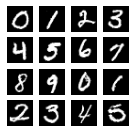

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.optimizers import RMSprop
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import load_model
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse

def build_generator(inputs, labels, image_size):
    image_resize = image_size // 4
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = concatenate([inputs, labels], axis=1)
    x = Dense(image_resize * image_resize * layer_filters[0])(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    generator = Model([inputs, labels], x, name='generator')
    return generator

def build_discriminator(inputs, labels, image_size):
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs

    y = Dense(image_size * image_size)(labels)
    y = Reshape((image_size, image_size, 1))(y)
    x = concatenate([x, y])

    for filters in layer_filters:
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model([inputs, labels], x, name='discriminator')
    return discriminator

def train(models, data, params):
    generator, discriminator, adversarial = models
    x_train, y_train = data
    batch_size, latent_size, train_steps, num_labels, model_name = params
    save_interval = 500
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    noise_class = np.eye(num_labels)[np.arange(0, 16) % num_labels]
    train_size = x_train.shape[0]
    print(model_name,
          np.argmax(noise_class, axis=1))

    for i in range(train_steps):
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        real_labels = y_train[rand_indexes]
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                          batch_size)]
        fake_images = generator.predict([noise, fake_labels])   
        x = np.concatenate((real_images, fake_images))
        labels = np.concatenate((real_labels, fake_labels))
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0.0
        loss, acc = discriminator.train_on_batch([x, labels], y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)    
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                           batch_size)]
        y = np.ones([batch_size, 1])
        loss, acc = adversarial.train_on_batch([noise, fake_labels], y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        if (i%100==0):
          print(log)
        if (i + 1) % save_interval == 0:
            if (i + 1) == train_steps:
                show = True
            else:
                show = False
            plot_images(generator,
                        noise_input=noise_input,
                        noise_class=noise_class,
                        show=show,
                        step=(i + 1),
                        model_name=model_name)
    generator.save(model_name + ".h5")

def plot_images(generator,
                noise_input,
                noise_class,
                show=False,
                step=0,
                model_name="gan"):
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict([noise_input, noise_class])
    print(model_name , " labels for generated images: ", np.argmax(noise_class, axis=1))
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

def build_and_train_models():
    (x_train, y_train), (_, _) = mnist.load_data()
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    num_labels = np.amax(y_train) + 1
    y_train = to_categorical(y_train)

    model_name = "cgan_mnist"
    latent_size = 100
    batch_size = 32
    train_steps = 160000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )
    inputs = Input(shape=input_shape, name='discriminator_input')
    labels = Input(shape=label_shape, name='class_labels')

    discriminator = build_discriminator(inputs, labels, image_size)
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, labels, image_size)
    generator.summary()
    optimizer = RMSprop(lr=lr*0.4, decay=decay*0.4)
    discriminator.trainable = False
    outputs = discriminator([generator([inputs, labels]), labels])
    adversarial = Model([inputs, labels],
                        outputs,
                        name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, latent_size, train_steps, num_labels, model_name)
    train(models, data, params)

def test_generator(generator, class_label=None):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    step = 0
    if class_label is None:
        num_labels = 10
        noise_class = np.eye(num_labels)[np.random.choice(num_labels, 16)]
    else:
        noise_class = np.zeros((16, 10))
        noise_class[:,class_label] = 1
        step = class_label

    plot_images(generator,
                noise_input=noise_input,
                noise_class=noise_class,
                show=True,
                step=step,
                model_name="test_outputs")
build_and_train_models()
    


